# Title

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F, MSELoss
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from models.unet import UNet
from models.autoencoder import Autoencoder
from utils.AddNoise import AddNoiseTransform


device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [2]:
# Add noise to the input images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy_images, -1.0, 1.0)  # Keep pixel values in [-1, 1]

In [3]:
# Customowy MNIST z zaszuionymi obrazami
dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        #AddNoiseTransform(noise_level=0.2),  # Add noise to the images
    ])
)
train_set, test_set = torch.utils.data.random_split(dataset, [50000, 10000])
train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True)

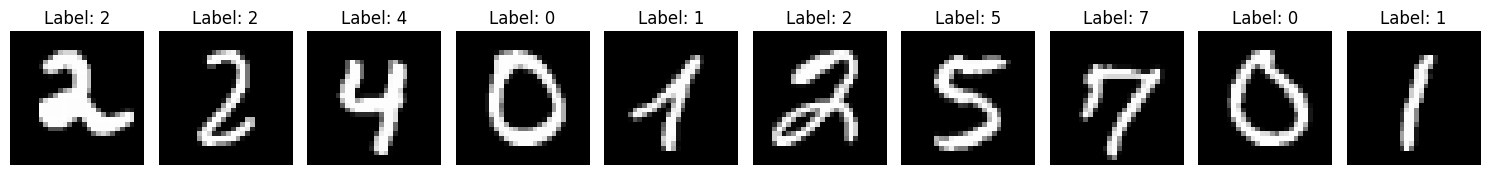

In [4]:
#plot the noisy image
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img, label = train_set[i]  # Get the image and label
    img = img.squeeze(0).numpy()  # Remove channel dimension and convert to numpy
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# Szum (Noise)

![Unet](./images/noise.jpg)
<br>
Szum to dodatkowe informacje, które nie są związane z obiektem obserwowanym. W przypadku obrazów cyfrowych szum to dodatkowe piksele, które nie są częścią obrazu. Mogą być one spowodowane zakłóceniami wynikającymi z konstukcji urządzenia przechwytującego obraz albo parametrów ekspozycji, wysokie ISO i słabe oświetlenie zazwyczaj prowadzą do zwiększenia szumu. Szum może pojawić się również na skutek obróbki obrazu, kompresji albo upscalingu.
<br>
Obecność szumu powoduje spadek jakości obrazu i oraz utratę zawartych w nim informacji, gdyż oryginalne wartości pixeli są zastępowane przez wartości losowe.

### Rodzaje szumu

### Jak zmierzyć szum?
Najczęściej stosowane są dwie metryki
-   Peak Signal to Noise Ratio (PSNR)
-   Structural Similarity Index (SSIM)

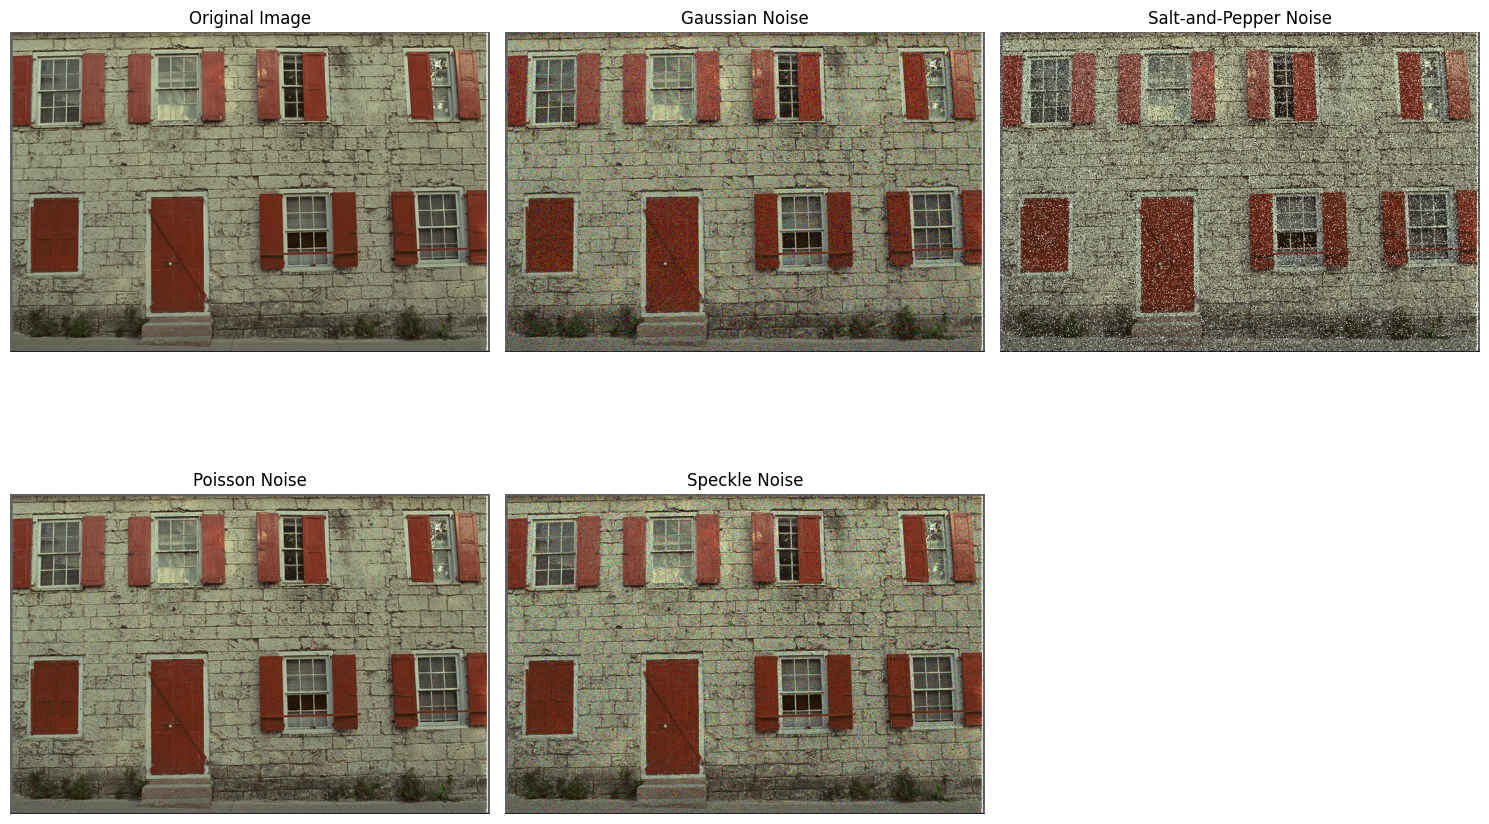

In [5]:
# Open the image
sample_image = Image.open('./data/kodak/kodim01.png')

# Convert the image to a NumPy array
image_array = np.array(sample_image, dtype=np.float32)

# Add Gaussian noise
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    # Clip the values to be within valid range (0-255 for an image)
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Add Salt-and-Pepper noise
def add_salt_and_pepper_noise(image, amount=0.05):
    noisy_image = image.copy()
    num_salt = int(amount * image.size * 0.5)
    num_pepper = int(amount * image.size * 0.5)

    # Add salt (white pixels)
    coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 255

    # Add pepper (black pixels)
    coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[coords[0], coords[1], :] = 0

    return noisy_image

# Add Poisson noise
def add_poisson_noise(image):
    noisy_image = np.random.poisson(image).astype(np.float32)
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Add Speckle noise
def add_speckle_noise(image, std=0.2):
    noise = np.random.randn(*image.shape) * std
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

# Apply different types of noise
noisy_gaussian = add_gaussian_noise(image_array)
noisy_salt_pepper = add_salt_and_pepper_noise(image_array, amount=0.05)
noisy_poisson = add_poisson_noise(image_array)
noisy_speckle = add_speckle_noise(image_array)

# Display the original and noisy images
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title('Gaussian Noise')
plt.imshow(Image.fromarray(noisy_gaussian.astype(np.uint8)))
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title('Salt-and-Pepper Noise')
plt.imshow(Image.fromarray(noisy_salt_pepper.astype(np.uint8)))
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title('Poisson Noise')
plt.imshow(Image.fromarray(noisy_poisson.astype(np.uint8)))
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title('Speckle Noise')
plt.imshow(Image.fromarray(noisy_speckle.astype(np.uint8)))
plt.axis('off')

plt.tight_layout()
plt.show()


# Odszumianie

W celu odszumiania stosowany jest szeroki zakres metod, począwszy od prostych filtrów Gaussa rozmywających obraz w celu ukrycia szumów bo różnego rodzaju rozwiązania oparte o metody uczenia maszynowego. Pierwszą architekturą szeroko sosowaną do takiego celu były Autoenkodery.

## Autoenkoder

Autoenkodery to modele składające się z dwóch części - enkodera i dekodera. Enkoder koduje wejściowy obraz do reprezentacji ukrytej, z której dekoder jest następnie w stanie "odzyskać" źródłowy obraz. Powoduje to że autoenkodery bardzo dobrze sprawdzają się w scenariuszach kompresji danych.<br>
Okazuje się, że po niewielkiej modyfikacji polegającej na zaszumieniu wejścia podczas treningu autoenkodery bardzo dobrze radzą sobie w odszumianiu danych, zwracąc na wyściu obraz pozbawiony szumów.

In [6]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-04)
epochs = 10

Zmodyfikowaliśmy trening autoencodera, tak aby dodać szum do przykładów treningowych, celem jest minimalizowanie kosztu pomiędzy rekonstrukcją obrazu a obrazem odszumionym -> w ten sposób jestesmy w stanie nauczyć autoenkoder odszumiania obrazków.

In [7]:
# Training loop
for epoch in range(epochs):
    model.train()
    for images, _ in train_dataloader:
        # Add noise to the images
        noisy_images = add_noise(images)

        # Forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Compare reconstructed images with clean images

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0538
Epoch [2/10], Loss: 0.0311
Epoch [3/10], Loss: 0.0254
Epoch [4/10], Loss: 0.0223
Epoch [5/10], Loss: 0.0196
Epoch [6/10], Loss: 0.0191
Epoch [7/10], Loss: 0.0178
Epoch [8/10], Loss: 0.0151
Epoch [9/10], Loss: 0.0155
Epoch [10/10], Loss: 0.0145


In [8]:
model.eval()
with torch.no_grad():
    for images, _ in test_dataloader:
        noisy_images = add_noise(images)
        outputs = model(noisy_images)
        break

Sprawdźmy jak poradził sobie model

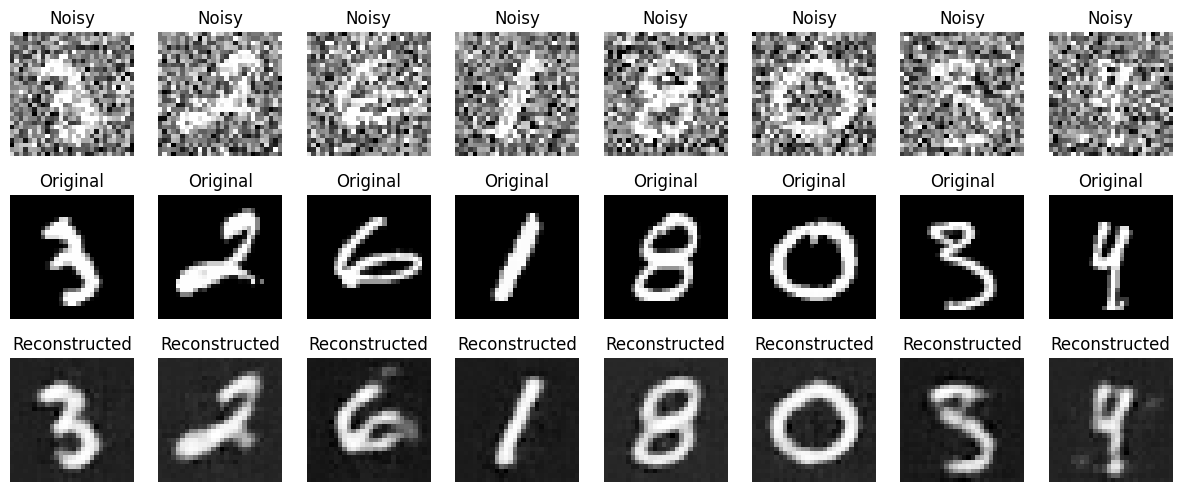

In [9]:
n = 8  # Number of images to display
plt.figure(figsize=(15, 6))
for i in range(n):
    # Noisy
    plt.subplot(3, n, i + 1)
    plt.imshow(noisy_images[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Noisy")

    # Original
    plt.subplot(3, n, i + 1 + n)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Original")

    # Reconstructed
    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(outputs[i].squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed")

plt.show()

Jak widać pomimo znacznego zaszumienia danych wejściowych, autoenkoder dość dobrze poradził sobie z ich odszumieniem.

## Diffusion

[zasada działania]

![Unet](./images/unet_diagram.jpg)

In [10]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

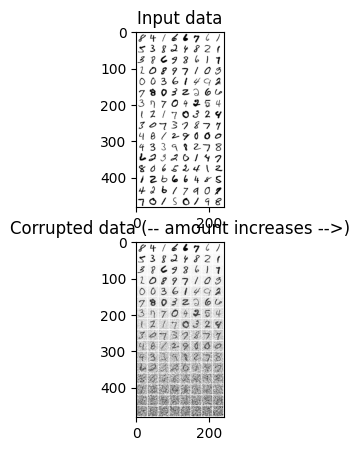

In [11]:
x, y = next(iter(train_dataloader))
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [12]:
lr=1e-3
unet = BasicUNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
criterion = nn.MSELoss()

NameError: name 'BasicUNet' is not defined

In [9]:
# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(10):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = unet(noisy_x)

        # Calculate the loss
        loss = criterion(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch {epoch}/10. Average loss: {avg_loss:05f}")

Epoch 0/10. Average loss: 0.013288
Epoch 1/10. Average loss: 0.013164
Epoch 2/10. Average loss: 0.013067
Epoch 3/10. Average loss: 0.012873
Epoch 4/10. Average loss: 0.012753
Epoch 5/10. Average loss: 0.012804
Epoch 6/10. Average loss: 0.012711
Epoch 7/10. Average loss: 0.012680
Epoch 8/10. Average loss: 0.012630
Epoch 9/10. Average loss: 0.012640


### Noise scheduler

## Inne